In [67]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl




# Creating a DataFrame

path = 'dataset/loan_dataset.csv'
df_original = pd.read_csv(path)
df_original.head()

df_original = pd.DataFrame(df_original)

# Filtering the specified columns
filtered_df = df_original[[
    'Employment_Status', 'Annual_Income', 'Credit_Score',  'Outstanding_Debt', 'Loan_Amount_Requested', 
    'Loan_Type','Loan_Purpose', 'Loan_Approval_Status'
]]

# 'Total_Existing_Loan_Amount'

filtered_df

,Employment_Status,Annual_Income,Credit_Score,Outstanding_Debt,Loan_Amount_Requested,Loan_Type,Loan_Purpose,Loan_Approval_Status
0,Employed,139901,743,19822,24535,Secured,Home,1
1,Employed,21162,468,18321,8288,Unsecured,Home,0
2,Self-Employed,27815,389,13851,10308,Secured,Vehicle,0
3,Self-Employed,137853,778,28608,33937,Secured,Personal,1
4,Employed,81753,752,8780,23360,Unsecured,Home,1
...,...,...,...,...,...,...,...,...
51995,Self-Employed,56085,381,11909,15723,Secured,Home,1
51996,Self-Employed,79062,726,24696,21209,Unsecured,Vehicle,1
51997,Unemployed,57471,396,12367,10540,Unsecured,Education,0
51998,Employed,49495,362,13240,16765,Secured,Vehicle,0


In [68]:
# Filter on home loan applications
filtered_df_home = filtered_df[filtered_df['Loan_Purpose'] == 'Home']


df = filtered_df_home.drop(columns=['Loan_Purpose'])
df

,Employment_Status,Annual_Income,Credit_Score,Outstanding_Debt,Loan_Amount_Requested,Loan_Type,Loan_Approval_Status
0,Employed,139901,743,19822,24535,Secured,1
1,Employed,21162,468,18321,8288,Unsecured,0
4,Employed,81753,752,8780,23360,Unsecured,1
8,Self-Employed,121626,803,13940,20239,Secured,0
10,Self-Employed,54670,772,22104,20000,Unsecured,1
...,...,...,...,...,...,...,...
51986,Self-Employed,105630,734,14841,26616,Unsecured,1
51989,Unemployed,118085,714,9803,30183,Secured,0
51990,Self-Employed,134581,756,15172,24717,Unsecured,1
51992,Unemployed,34019,572,19031,8383,Unsecured,0


In [69]:
nan_count = df.isna().sum()
print(nan_count)

Employment_Status        0
Annual_Income            0
Credit_Score             0
Outstanding_Debt         0
Loan_Amount_Requested    0
Loan_Type                0
Loan_Approval_Status     0
dtype: int64


# fuzzification

documentation: https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_tipping_problem_newapi.html

/Users/brageramberg/opt/miniconda3/envs/INF264/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


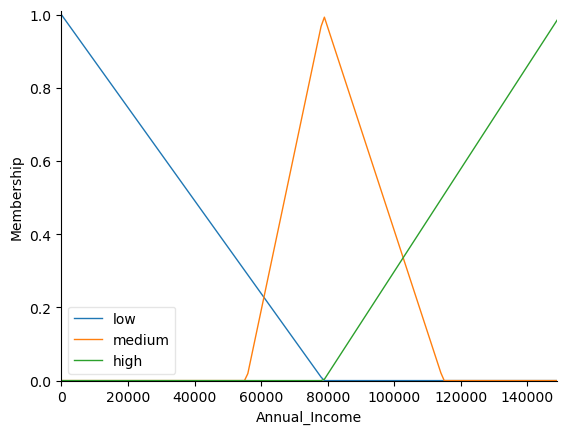

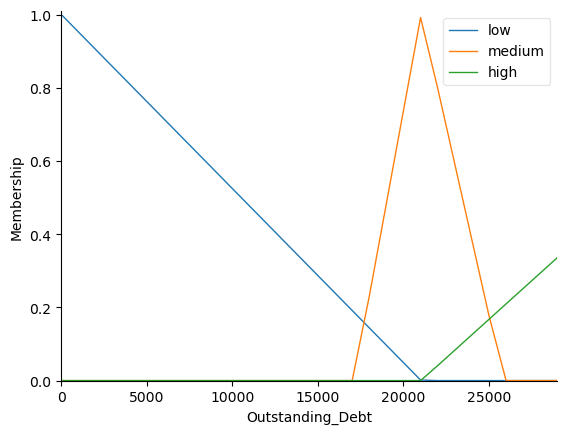

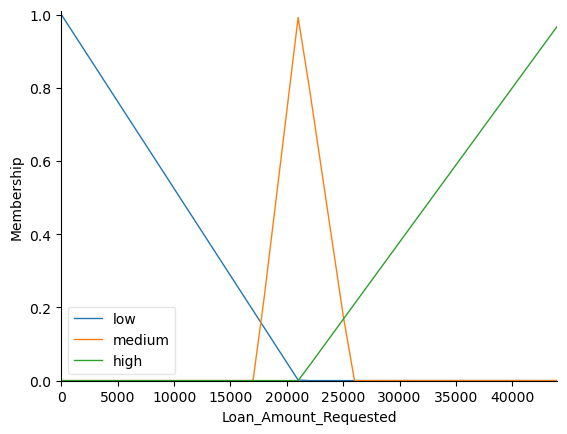

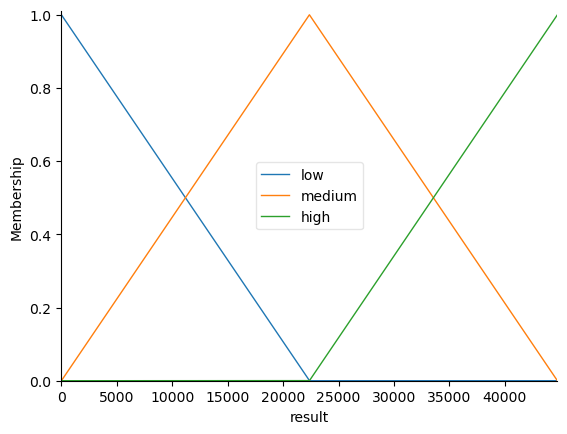

In [70]:
# Calculating the max, min, and average of 'Annual_income' column
max_income = df['Annual_Income'].max()
max_loan = df['Loan_Amount_Requested'].max()
max_outstanding_debt = df['Outstanding_Debt'].max()

def custom_fuzzification(antecedent, data, column_name):
    """
    Sets up 'low', 'medium', and 'high' fuzzy membership functions for a given column in the data.
    
    Parameters:
    - antecedent: The fuzzy antecedent to apply the memberships to (e.g., annual_income).
    - data: The DataFrame containing the data.
    - column_name: The column name to base the membership functions on.
    """
    # Calculate cutoffs dynamically
    low_cutoff = data[column_name].quantile(0.5)
    medium_cutoff_start = data[column_name].quantile(0.25)
    medium_cutoff_middle = data[column_name].quantile(0.5)
    medium_cutoff_end = data[column_name].quantile(0.75)
    max_income_end = data[column_name].max()
    
    # Define triangular membership functions
    antecedent['low'] = fuzz.trimf(antecedent.universe, [0, 0, low_cutoff])
    antecedent['medium'] = fuzz.trimf(antecedent.universe, [medium_cutoff_start, medium_cutoff_middle, medium_cutoff_end])
    antecedent['high'] = fuzz.trimf(antecedent.universe, [medium_cutoff_middle, max_income_end, max_income_end])

# Custom fuzzification function
annual_income = ctrl.Antecedent(np.arange(0, max_income, 1000), 'Annual_Income')
loan_amount_requested= ctrl.Antecedent(np.arange(0, max_loan, 1000), 'Loan_Amount_Requested')
outstanding_debt = ctrl.Antecedent(np.arange(0, max_outstanding_debt, 1000), 'Outstanding_Debt')



# maybe average later or not
result = ctrl.Consequent(np.arange(0, max_loan+1, 1), 'result')
result['low'] = fuzz.trimf(result.universe, [0, 0, max_loan/2])
result['medium'] = fuzz.trimf(result.universe, [0, max_loan/2, max_loan])
result['high'] = fuzz.trimf(result.universe, [max_loan/2, max_loan, max_loan])


# Apply the custom fuzzification function
custom_fuzzification(annual_income, df, "Annual_Income")
custom_fuzzification(loan_amount_requested, df, "Loan_Amount_Requested")
custom_fuzzification(outstanding_debt, df, "Loan_Amount_Requested")

annual_income.view()
outstanding_debt.view()
loan_amount_requested.view()
result.view()



# rules

In [71]:

# Rule 1: Low income and low debt result in a low loan amount
rule1 = ctrl.Rule(annual_income['low'] & outstanding_debt['low'], result['low'])

# Rule 2: Medium income and low debt result in a medium loan amount
rule2 = ctrl.Rule(annual_income['medium'] & outstanding_debt['low'], result['medium'])

# Rule 3: High income and low debt result in a high loan amount
rule3 = ctrl.Rule(annual_income['high'] & outstanding_debt['low'], result['high'])

# Define the control system with all rules
loan_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])

# Create a simulation instance
loan = ctrl.ControlSystemSimulation(loan_ctrl)

# Set inputs
loan.input['Annual_Income'] = 80000
loan.input['Outstanding_Debt'] = 210000

# Compute the result
loan.compute()

# Output the result
print("Result:", loan.output['result'])

# Visualize the output
result.view(sim=loan)

KeyError: 'result'

In [ ]:

# Rule 1: Low income and low debt result in a low loan amount
rule1 = ctrl.Rule(annual_income['low'] & outstanding_debt['low'], result['low'])

# Rule 2: Medium income and low debt result in a medium loan amount
rule2 = ctrl.Rule(annual_income['medium'] & outstanding_debt['low'], result['medium'])

# Rule 3: High income and low debt result in a high loan amount
rule3 = ctrl.Rule(annual_income['high'] & outstanding_debt['low'], result['high'])

# # Rule 4: Low income and medium debt result in a low loan amount
# rule4 = ctrl.Rule(annual_income['low'] & outstanding_debt['medium'], result['low'])

# # Rule 5: Medium income and medium debt result in a medium loan amount
# rule5 = ctrl.Rule(annual_income['medium'] & outstanding_debt['medium'], result['medium'])

# # Rule 6: High income and medium debt result in a high loan amount
# rule6 = ctrl.Rule(annual_income['high'] & outstanding_debt['medium'], result['high'])

# # Rule 7: Low income and high debt result in a low loan amount
# rule7 = ctrl.Rule(annual_income['low'] & outstanding_debt['high'], result['low'])

# # Rule 8: Medium income and high debt result in a medium loan amount
# rule8 = ctrl.Rule(annual_income['medium'] & outstanding_debt['high'], result['low'])

# # Rule 9: High income and high debt result in a high loan amount
# rule9 = ctrl.Rule(annual_income['high'] & outstanding_debt['high'], result['medium'])



loan_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
loan = ctrl.ControlSystemSimulation(loan_ctrl)
loan.input['Annual_Income'] = 80000
loan.input['Outstanding_Debt'] = 210000

# Crunch the numbers
loan.compute()
print(loan.output['result'])
result.view(sim=loan)

KeyError: 'result'

19.847607361963195


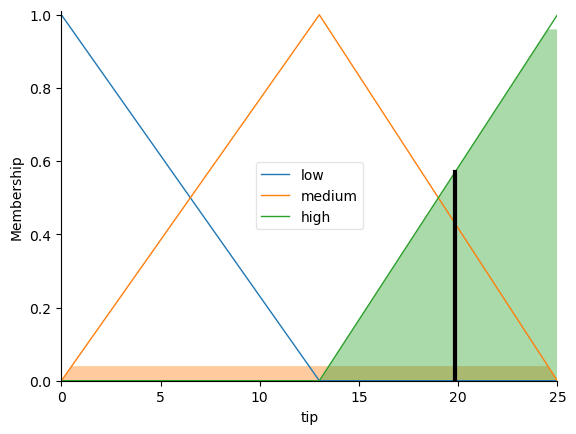

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
quality = ctrl.Antecedent(np.arange(0, 11, 1), 'quality')
service = ctrl.Antecedent(np.arange(0, 11, 1), 'service')
tip = ctrl.Consequent(np.arange(0, 26, 1), 'tip')

# Auto-membership function population is possible with .automf(3, 5, or 7)
quality.automf(3)
service.automf(3)

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
tip['low'] = fuzz.trimf(tip.universe, [0, 0, 13])
tip['medium'] = fuzz.trimf(tip.universe, [0, 13, 25])
tip['high'] = fuzz.trimf(tip.universe, [13, 25, 25])

rule1 = ctrl.Rule(quality['poor'] | service['poor'], tip['low'])
rule2 = ctrl.Rule(service['average'], tip['medium'])
rule3 = ctrl.Rule(service['good'] | quality['good'], tip['high'])


tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
tipping = ctrl.ControlSystemSimulation(tipping_ctrl)


# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
tipping.input['quality'] = 6.5
tipping.input['service'] = 9.8

# Crunch the numbers
tipping.compute()

print(tipping.output['tip'])
tip.view(sim=tipping)